In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tqdm import tqdm
import cv2

from model import Yolo
from loss import YoloLoss

e:\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PIL import Image

# Open the image file
with Image.open('sample/data/000000.png') as img:
    # Get the width and height of the image
    Image_Width, Image_Height = img.size
    print(f"Image size: {Image_Width} x {Image_Height}")


#kitti dataset의 실제크기, resize를 위해 파악

Image size: 1242 x 375


In [3]:

torch.cuda.is_available() 
print(torch.cuda.device_count())

0


### 라벨 전처리

In [4]:
# [class],[Pc = confidence score],[x], [y], [w], [h],[distance] = 0~7 c x y w h dist


In [5]:
# column_names=['class','truncated','occluded','alpha','x1','y1','x2','y2','dimensions_h','dimensions_w','dimensions_len','location_x','location_y','distance','rotation_y']
# one_hot_labeling={'Car':0, 'Van':1, 'Truck':2,'Pedestrian':3, 'Person_sitting':4, 'Cyclist':5, 'Tram':6,'Misc':7, 'DontCare':7}        #Misc and DontCare is same value


# import os

# folder_path = "dataset/training/label_2"

# #txt파일 단위로 불러옴
# for filename in tqdm(os.listdir(folder_path)):
#     temp=pd.read_csv(folder_path+'/'+filename,delimiter=' ',names=column_names)
#     temp=temp.drop(columns=['truncated','occluded','alpha','dimensions_h','dimensions_w','dimensions_len','location_x','location_y','rotation_y'])

#     #class one hot vector로 변환
#     data = np.array(list(map(lambda x:one_hot_labeling[x],list(temp['class'])))).reshape(-1, 1)

#     encoder = OneHotEncoder(categories=[range(8)], sparse=False,dtype=int)
#     encoder.fit(data)
#     onehot = encoder.transform(data)

#     one_hot=pd.DataFrame(data=onehot,columns=[f'class_{i}' for i in range(8)])
#     one_hot
#     temp=pd.concat([one_hot,temp],axis=1)
#     temp=temp.drop(columns=['class'])

#     temp

#     # 좌표 resize 416* 416
#     temp['x1'] = ((416.0/Image_Width)*temp['x1'])
#     temp['y1'] = ((416.0/Image_Height)*temp['y1'])
#     temp['x2'] = ((416.0/Image_Width)*temp['x2'])
#     temp['y2'] = ((416.0/Image_Height)*temp['y2'])

#     # x y w h 형식으로 bbox 변환 (여기서 x y는 중심좌표,)
#     temp['x1'] = (temp['x1'] + temp['x2'])/2.0
#     temp['y1'] = (temp['y1'] + temp['y2'])/2.0
#     temp['x2'] = temp['x2'] - temp['x1']
#     temp['y2'] = temp['y2'] - temp['y1']

#     temp.rename(columns = {'x1' : 'x','y1' : 'y','x2' : 'w','y2' : 'h'}, inplace = True)

#     #txt형태로 파일 덮어쓰기 
#     temp.to_csv(folder_path+'/'+filename,sep=' ',index = False , header=None)


# # # #이후 데이터셋에서 텐서로 바꿀때 index 8에 c score 자리 만들기


In [6]:
int(416/32)


13

### custom dataset

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    # S= grid cell, B= num of anchors, C = num of classes
    def __init__(self, folder_dir, img_dir, label_dir, S=13, B=5, C=8, transform=None):         
        self.img_folder=folder_dir[0]
        self.label_folder=folder_dir[1]
        self.img_path=img_dir
        self.label_path=label_dir
        
        self.S=S
        self.B=B
        self.C=C
        self.transform=transform
        
    def __len__(self):
        return len(self.img_path)
        

    def __getitem__(self, idx):
        
        #image 전처리
        
        image_filepath = self.img_folder+self.img_path[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        image=image.transpose(2,0,1)
        image=torch.from_numpy(image).float().div(255.0)
        image.requires_grad=True
        #label 추가 전처리

        bboxes=np.loadtxt(self.label_folder+self.label_path[idx]).tolist()

        label_matrix = torch.zeros((self.S, self.S, self.C+6 )) # 13*13*14(class(8) + c_score x y w h distance)

        try:
            for bbox in bboxes:
                i=0
                j=0
                class_label=list(map(int,bbox[:8])) 
                x, y=bbox[8],bbox[9]
                width, height= bbox[10],bbox[11]
                distance= bbox[12]

                # x, y의 위치 grid cell 파악하기
                x_cell = int(x/32) # 0~12
                y_cell = int(y/32) # 0~12
                x_val_inCell = float((x - x_cell * 32.0)/32.0) # 0.0 ~ 1.0
                y_val_inCell = float((y - y_cell * 32.0)/32.0) # 0.0 ~ 1.0

                # w, h 를 0~1 사이의 값으로 만들기
                w = width / 416.0
                h = height / 416.0

                label_matrix[y_cell, x_cell, 8] = 1.0                                       #c_score 8
                label_matrix[y_cell, x_cell, class_label.index(max(class_label))] = 1.0     #idx 0~7
                label_matrix[y_cell, x_cell, 9] = x_val_inCell                              #bbox 9~12
                label_matrix[y_cell, x_cell, 10] = y_val_inCell
                label_matrix[y_cell, x_cell, 11] = w
                label_matrix[y_cell, x_cell, 12] = h
                label_matrix[y_cell, x_cell, 13] = distance                                 #distance 13

        # single label
        except TypeError as e:
            i=0
            j=0
            bbox=bboxes
            class_label=list(map(int,bbox[:8])) 
            x, y=bbox[8],bbox[9]
            width, height= bbox[10],bbox[11]
            distance= bbox[12]

            # x, y의 위치 grid cell 파악하기
            x_cell = int(x/32) # 0~12
            y_cell = int(y/32) # 0~12
            x_val_inCell = float((x - x_cell * 32.0)/32.0) # 0.0 ~ 1.0
            y_val_inCell = float((y - y_cell * 32.0)/32.0) # 0.0 ~ 1.0

            # w, h 를 0~1 사이의 값으로 만들기
            w = width / 416.0
            h = height / 416.0

            label_matrix[y_cell, x_cell, 8] = 1.0                                       #c_score 8
            label_matrix[y_cell, x_cell, class_label.index(max(class_label))] = 1.0     #idx 0~7
            label_matrix[y_cell, x_cell, 9] = x_val_inCell                              #bbox 9~12
            label_matrix[y_cell, x_cell, 10] = y_val_inCell
            label_matrix[y_cell, x_cell, 11] = w
            label_matrix[y_cell, x_cell, 12] = h
            label_matrix[y_cell, x_cell, 13] = distance                                 #distance 13

        return image, label_matrix

In [8]:
img_label_folder_path=['dataset/data_object_image_2/training/image_2/','dataset/training/label_2/']
img_path=os.listdir('dataset/data_object_image_2/training/image_2/')
label_path=os.listdir('dataset/training/label_2/')
dset=CustomDataset(img_label_folder_path,img_path,label_path)

In [9]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dset, batch_size=4, shuffle=True)

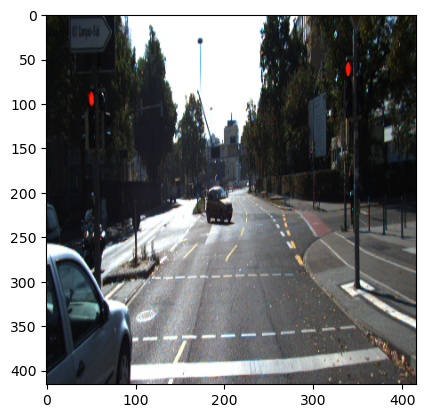

In [10]:
import matplotlib.pyplot as plt

for batch_idx, (inputs, labels) in enumerate(dataloader):
    
    inputs= inputs[0]
    inputs = inputs.permute(1,2,0)
    # print(inputs.shape)
    plt.figure()
    plt.imshow(inputs.detach().numpy())
    plt.show()
    break

### model training

In [11]:
model = Yolo(8)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-500000) 
criterion=YoloLoss()

In [12]:
nb_epochs = 5
for epoch in range(nb_epochs + 1):
  for batch_idx, samples in tqdm(enumerate(dataloader)):
    # print(batch_idx)
    # print(samples)
    x_train, y_train = samples
    # H(x) 계산
    prediction = model(x_train)
    # cost 계산
    cost = criterion(prediction, y_train)
    # cost로 H(x) 계산
    optimizer.zero_grad()
    cost.sum().backward()
    optimizer.step()

    print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        epoch, nb_epochs, batch_idx+1, len(dataloader),
        cost.sum().item()
        ))

1it [00:04,  4.18s/it]

Epoch    0/5 Batch 1/1871 Cost: 26473476.000000


2it [00:08,  4.20s/it]

Epoch    0/5 Batch 2/1871 Cost: 31668058.000000


3it [00:12,  4.27s/it]

Epoch    0/5 Batch 3/1871 Cost: 8469413.000000


4it [00:17,  4.29s/it]

Epoch    0/5 Batch 4/1871 Cost: 51410648.000000


5it [00:21,  4.29s/it]

Epoch    0/5 Batch 5/1871 Cost: 16268332.000000


6it [00:25,  4.32s/it]

Epoch    0/5 Batch 6/1871 Cost: 13930718.000000


7it [00:30,  4.33s/it]

Epoch    0/5 Batch 7/1871 Cost: 36133248.000000


8it [00:34,  4.33s/it]

Epoch    0/5 Batch 8/1871 Cost: 52598208.000000


9it [00:38,  4.32s/it]

Epoch    0/5 Batch 9/1871 Cost: 31361276.000000


9it [00:43,  4.78s/it]


KeyboardInterrupt: 